# Damped pendulum and prediction by SciNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from tqdm import tqdm
from pathlib import Path
import gc

## 1. We create data: sinusoidal amortized wave

In [2]:
def data_synthetic_pendulum(kapa, b, timesteps=50, maxtime=5.0, m=1.0, A0=1.0, phi=0.0, t: np.array = None):
    if t is None:
        t = np.linspace(0, maxtime, timesteps)
    w = np.sqrt(kapa / m) * np.sqrt(1 - b**2/(4*m*kapa))
    A = A0 * np.exp(-b * t / (2*m))

    return A * np.cos(w * t + phi)

In [3]:
def plot_synthetic_pendulum(timeserie, timesteps=50, maxtime=5.0):
    t = np.linspace(0, maxtime, timesteps)
    y = timeserie
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

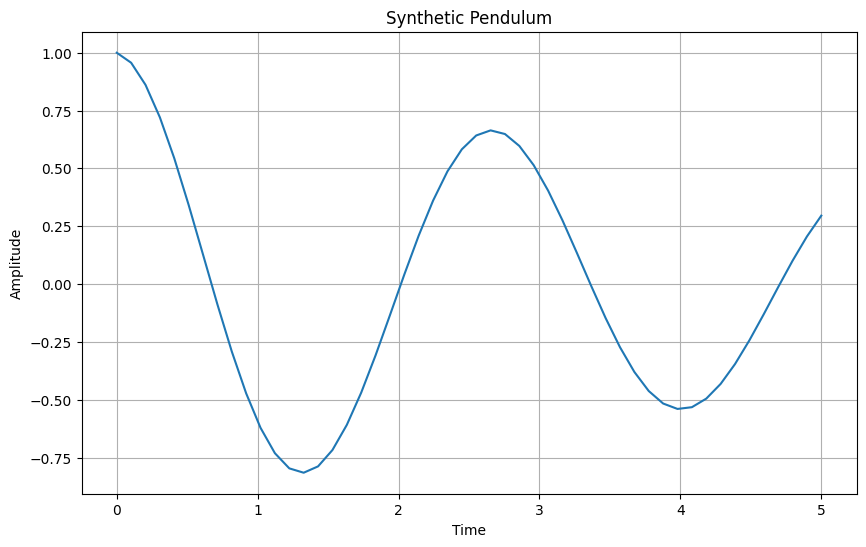

In [4]:
kapa_range = (5.0, 6.0)
b_range = (0.2, 0.5)
kapa = np.random.uniform(*kapa_range)
b = np.random.uniform(*b_range)
pendulum1 = data_synthetic_pendulum(kapa, b)
plot_synthetic_pendulum(pendulum1)

In [5]:
def build_dataset(num_samples=1000, kapa_range=(3.0, 8.0), b_range=(0.1, 1.0), maxtime=5.0, timesteps=50):
    observations = []
    questions = []
    params = []
    a_corr = []
    for _ in range(num_samples):
        # Build observations
        kapa = np.random.uniform(*kapa_range)
        b = np.random.uniform(*b_range)
        params.append((kapa, b))
        timeserie = data_synthetic_pendulum(kapa, b, timesteps=timesteps, maxtime=maxtime)
        observations.append(timeserie)
        # Build questions
        question = np.random.uniform(0, maxtime*2)
        questions.append(question)
        # Build answer to the question
        a_corr.append(data_synthetic_pendulum(kapa, b, t=np.array(question), maxtime=maxtime, timesteps=50))
    return np.array(observations), np.array(questions), np.array(a_corr), np.array(params)

In [6]:
class PendulumDataset(Dataset):
    def __init__(self, observations, questions, answers, params):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.questions = torch.tensor(questions, dtype=torch.float32)
        self.answers = torch.tensor(answers, dtype=torch.float32)
        self.params = torch.tensor(params, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.questions[idx], self.answers[idx], self.params[idx]

In [7]:
N_samples = 10000
kapa_range = (5.0, 6.0)
b_range = (0.2, 0.5)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

dataset = PendulumDataset(observations, questions, answers, params)

In [8]:
train_valid_rate = 0.8
train_size = int(train_valid_rate * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

## 2. Create SciNet

In [9]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

In [10]:
# Test Encoder
batch_size = 10
input_size = 50
latent_size = 3
hidden_sizes = [128, 64]

x = torch.randn((batch_size, input_size))
encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=hidden_sizes)
mean, logvar = encoder(x)

assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

torch.cuda.empty_cache()
del x, encoder, mean, logvar
gc.collect()

3293

In [11]:
class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1, 
                 output_size: int = 1, 
                 hidden_sizes: list = [64, 32]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z

In [12]:
# Test Decoder
batch_size = 10
latent_size = 3
question_size = 1
hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, latent_size))
question = torch.randn((batch_size, question_size))
decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=hidden_sizes)
possible_answer = decoder(x, question)

assert possible_answer.shape == (batch_size, output_size)

torch.cuda.empty_cache()
del x, question, decoder, possible_answer
gc.collect()

0

In [13]:
class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 enc_hidden_sizes: list[int] = [500, 100], 
                 latent_size: int = 10, 
                 question_size: int = 1,
                 dec_hidden_sizes: list[int] = [100, 100], 
                 output_size: int = 1
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

In [14]:
# Test PendulumNet

batch_size = 10
input_size
enc_hidden_sizes = [128, 64]
latent_size = 3
question_size = 1
dec_hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

assert possible_answer.shape == (batch_size, output_size)
assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

torch.cuda.empty_cache()
del model, x, question, possible_answer, mean, logvar
gc.collect()

0

In [15]:
def scinet_loss(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.001
        ) -> torch.Tensor:
    # prediction_loss = nn.MSELoss(reduction='none')(possible_answer, a_corr)
    # kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).unsqueeze(-1)
    # total_loss = prediction_loss + beta * kld_loss
    # return torch.mean(total_loss)

    recon_loss = nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

In [16]:
# Test loss function

batch_size = 10
input_size
enc_hidden_sizes = [500, 100]
latent_size = 3
question_size = 1
dec_hidden_sizes = [100, 100]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

a_corr = torch.randn((batch_size, output_size))
beta = 0.01
loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta)

assert loss[0].shape == ()
assert len(loss) == 3

torch.cuda.empty_cache()
del model, x, question, possible_answer, mean, logvar, a_corr, loss
gc.collect()

0

## 3. Training loop

In [17]:
from magnetics_diagnostic_analysis.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [18]:
# Params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
batch_size1 = 512
batch_size2 = 512

m_input_size = 50
m_enc_hidden_sizes = [500, 100]
m_latent_size = 3
m_question_size = 1
m_dec_hidden_sizes = [100, 100]
m_output_size = 1

learning_rate = 1e-4
num_epochs = 150
kld_beta = 0.01
es_patience = 7
es_min_delta = 1e-4
gc_max_grad_norm = 1.0
lrs_factor = 0.66
lrs_patience = 5
lrs_min_lr = 1e-8
lrs_min_delta = 1e-4

Using device: cuda


In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size2, shuffle=False)

In [20]:
pendulum_net = PendulumNet(
    input_size=m_input_size, 
    enc_hidden_sizes=m_enc_hidden_sizes, 
    latent_size=m_latent_size, 
    question_size=m_question_size, 
    dec_hidden_sizes=m_dec_hidden_sizes, 
    output_size=m_output_size
)

optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=learning_rate)
early_stopper = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
gradient_clipper = GradientClipping(max_norm=gc_max_grad_norm)
lr_scheduler = LRScheduling(optimizer, factor=lrs_factor, patience=lrs_patience, min_lr=lrs_min_lr, min_delta=lrs_min_delta)

In [ ]:
# Training loop

def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, a_corr, _ in tqdm(train_loader, desc="Training", leave=False):
            observations = observations.to(device)
            questions = questions.to(device).unsqueeze(-1)
            a_corr = a_corr.to(device).unsqueeze(-1)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, a_corr, _ in tqdm(valid_loader, desc="Validation", leave=False):
                observations = observations.to(device)
                questions = questions.to(device).unsqueeze(-1)
                a_corr = a_corr.to(device).unsqueeze(-1)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        # path = Path().absolute() / 'pendulum_scinet.pth'
        # torch.save(model.state_dict(), path)

        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [22]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=num_epochs, 
    kld_beta=kld_beta, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

------training on cuda-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  0.154010         |  0.023599     0.153774        |    0.152729       


2/150                 |  0.147308         |  0.075444     0.146554        |    0.150621       


3/150                 |  0.146016         |  0.048761     0.145529        |    0.149943       


4/150                 |  0.144908         |  0.015261     0.144756        |    0.149823       


5/150                 |  0.144569         |  0.003289     0.144536        |    0.148516       


6/150                 |  0.144553         |  0.002639     0.144527        |    0.148812       


7/150                 |  0.143818         |  0.003426     0.143783        |    0.149128       


8/150                 |  0.143401         |  0.002844     0.143373        |    0.148602       


9/150                 |  0.143595         |  0.002112     0.143574        |    0.148043       


10/150                |  0.143467         |  0.002078     0.143446        |    0.147218       


11/150                |  0.142802         |  0.002392     0.142778        |    0.146852       


12/150                |  0.142440         |  0.003212     0.142408        |    0.146680       


13/150                |  0.142535         |  0.001983     0.142515        |    0.146249       


14/150                |  0.142237         |  0.002047     0.142216        |    0.147069       


15/150                |  0.141591         |  0.003108     0.141560        |    0.146996       


16/150                |  0.141546         |  0.003276     0.141513        |    0.146110       


17/150                |  0.141293         |  0.002761     0.141265        |    0.145489       


18/150                |  0.140890         |  0.003342     0.140857        |    0.145687       


19/150                |  0.140440         |  0.003363     0.140407        |    0.145936       


20/150                |  0.140328         |  0.004338     0.140285        |    0.145113       


21/150                |  0.140337         |  0.002941     0.140307        |    0.144574       


22/150                |  0.140025         |  0.003309     0.139992        |    0.144468       


23/150                |  0.140080         |  0.002941     0.140051        |    0.144673       


24/150                |  0.139980         |  0.004091     0.139939        |    0.143974       


25/150                |  0.139406         |  0.003998     0.139366        |    0.143883       


26/150                |  0.139017         |  0.004043     0.138976        |    0.143952       


27/150                |  0.138699         |  0.004837     0.138650        |    0.143374       


28/150                |  0.138748         |  0.003296     0.138715        |    0.143531       


29/150                |  0.138256         |  0.005031     0.138206        |    0.142715       


30/150                |  0.137907         |  0.005088     0.137857        |    0.142371       


31/150                |  0.137913         |  0.004317     0.137870        |    0.141731       


32/150                |  0.137171         |  0.007183     0.137099        |    0.141191       


33/150                |  0.137067         |  0.004677     0.137020        |    0.141795       


34/150                |  0.136995         |  0.005428     0.136940        |    0.141527       


35/150                |  0.137091         |  0.007285     0.137018        |    0.140793       


36/150                |  0.136319         |  0.006310     0.136256        |    0.140602       


37/150                |  0.136308         |  0.006462     0.136243        |    0.140476       


38/150                |  0.135630         |  0.007083     0.135560        |    0.139703       


39/150                |  0.135580         |  0.006655     0.135514        |    0.139500       


40/150                |  0.135091         |  0.009156     0.134999        |    0.139809       


41/150                |  0.134756         |  0.005321     0.134703        |    0.139241       


42/150                |  0.134688         |  0.007722     0.134611        |    0.138910       


43/150                |  0.133852         |  0.008969     0.133762        |    0.138395       


44/150                |  0.133898         |  0.008539     0.133813        |    0.137966       


45/150                |  0.133524         |  0.007263     0.133451        |    0.137709       


46/150                |  0.133230         |  0.008579     0.133144        |    0.136789       


47/150                |  0.132713         |  0.009717     0.132616        |    0.137455       


48/150                |  0.132483         |  0.011197     0.132371        |    0.136439       


49/150                |  0.131926         |  0.008833     0.131837        |    0.135934       


50/150                |  0.131247         |  0.009870     0.131148        |    0.135875       


51/150                |  0.131380         |  0.009219     0.131288        |    0.135328       


52/150                |  0.130959         |  0.013844     0.130821        |    0.135209       


53/150                |  0.130686         |  0.009609     0.130590        |    0.134275       


54/150                |  0.130118         |  0.011881     0.129999        |    0.134609       


55/150                |  0.129811         |  0.011580     0.129695        |    0.133447       


56/150                |  0.129304         |  0.011201     0.129192        |    0.133361       


57/150                |  0.128869         |  0.012925     0.128740        |    0.133677       


58/150                |  0.128435         |  0.013926     0.128296        |    0.131965       


59/150                |  0.128218         |  0.013736     0.128080        |    0.131542       


60/150                |  0.127673         |  0.014769     0.127526        |    0.131359       


61/150                |  0.127091         |  0.011009     0.126981        |    0.130969       


62/150                |  0.126858         |  0.015694     0.126701        |    0.130963       


63/150                |  0.126729         |  0.013385     0.126596        |    0.130076       


64/150                |  0.126291         |  0.016172     0.126129        |    0.129858       


65/150                |  0.125514         |  0.016747     0.125346        |    0.130413       


66/150                |  0.125397         |  0.013412     0.125262        |    0.129583       


67/150                |  0.124767         |  0.014581     0.124621        |    0.128800       


68/150                |  0.124414         |  0.015201     0.124262        |    0.129026       


69/150                |  0.123807         |  0.019464     0.123612        |    0.126832       


70/150                |  0.123399         |  0.014828     0.123251        |    0.125912       


71/150                |  0.122581         |  0.017635     0.122405        |    0.126996       


72/150                |  0.122576         |  0.019472     0.122382        |    0.125841       


73/150                |  0.121785         |  0.015471     0.121630        |    0.125602       


74/150                |  0.121720         |  0.019577     0.121524        |    0.125241       


75/150                |  0.121489         |  0.024854     0.121240        |    0.123961       


76/150                |  0.120627         |  0.019473     0.120432        |    0.123946       


77/150                |  0.120160         |  0.015853     0.120001        |    0.123098       


78/150                |  0.119826         |  0.021148     0.119614        |    0.122228       


79/150                |  0.119427         |  0.022028     0.119207        |    0.122344       


80/150                |  0.118540         |  0.022609     0.118314        |    0.122130       


81/150                |  0.118580         |  0.021490     0.118366        |    0.121744       


82/150                |  0.117740         |  0.023697     0.117503        |    0.121222       


83/150                |  0.116683         |  0.021203     0.116471        |    0.120311       


84/150                |  0.116936         |  0.018784     0.116748        |    0.120391       


85/150                |  0.116628         |  0.021761     0.116410        |    0.119499       


86/150                |  0.115604         |  0.028322     0.115320        |    0.118484       


87/150                |  0.115552         |  0.021871     0.115333        |    0.118428       


88/150                |  0.114776         |  0.022784     0.114548        |    0.117739       


89/150                |  0.114459         |  0.021597     0.114243        |    0.116450       


90/150                |  0.113910         |  0.019462     0.113716        |    0.116548       


91/150                |  0.113668         |  0.020902     0.113459        |    0.115749       


92/150                |  0.113110         |  0.021009     0.112900        |    0.117167       


93/150                |  0.112856         |  0.019121     0.112665        |    0.115530       


94/150                |  0.111841         |  0.021290     0.111628        |    0.115356       


95/150                |  0.111928         |  0.017657     0.111752        |    0.113808       


96/150                |  0.111628         |  0.030654     0.111322        |    0.113822       


97/150                |  0.110860         |  0.024547     0.110615        |    0.112702       


98/150                |  0.110673         |  0.020536     0.110468        |    0.112036       


99/150                |  0.110134         |  0.023035     0.109904        |    0.112761       


100/150               |  0.110070         |  0.021654     0.109853        |    0.111749       


101/150               |  0.109189         |  0.025092     0.108938        |    0.112616       


102/150               |  0.109527         |  0.019777     0.109329        |    0.111969       


103/150               |  0.108873         |  0.020861     0.108665        |    0.110448       


104/150               |  0.107971         |  0.022912     0.107742        |    0.109758       


105/150               |  0.107873         |  0.022616     0.107647        |    0.110368       


106/150               |  0.107189         |  0.024738     0.106942        |    0.108943       


107/150               |  0.106872         |  0.021522     0.106657        |    0.108482       


108/150               |  0.106230         |  0.023350     0.105996        |    0.108900       


109/150               |  0.106382         |  0.023146     0.106150        |    0.108636       


110/150               |  0.106038         |  0.025018     0.105788        |    0.108024       


111/150               |  0.105330         |  0.020760     0.105123        |    0.107232       


112/150               |  0.105130         |  0.021525     0.104914        |    0.106876       


113/150               |  0.104460         |  0.020458     0.104255        |    0.107044       


114/150               |  0.104514         |  0.021773     0.104296        |    0.105982       


115/150               |  0.103806         |  0.020367     0.103602        |    0.105659       


116/150               |  0.103681         |  0.020004     0.103481        |    0.105766       


117/150               |  0.103058         |  0.022592     0.102832        |    0.104471       


118/150               |  0.102907         |  0.019089     0.102716        |    0.104162       


119/150               |  0.102523         |  0.021730     0.102306        |    0.104233       


120/150               |  0.102283         |  0.020150     0.102081        |    0.103786       


121/150               |  0.101774         |  0.022145     0.101553        |    0.103202       


122/150               |  0.101692         |  0.021808     0.101474        |    0.103243       


123/150               |  0.101259         |  0.020856     0.101051        |    0.102811       


124/150               |  0.100887         |  0.022485     0.100662        |    0.102201       


125/150               |  0.100687         |  0.024547     0.100442        |    0.101976       


126/150               |  0.100081         |  0.020924     0.099872        |    0.102934       


127/150               |  0.100443         |  0.019141     0.100252        |    0.101288       


128/150               |  0.099496         |  0.019510     0.099300        |    0.101049       


129/150               |  0.099295         |  0.019558     0.099099        |    0.100973       


130/150               |  0.099020         |  0.021626     0.098803        |    0.100525       


131/150               |  0.098870         |  0.018486     0.098685        |    0.100088       


132/150               |  0.098539         |  0.022291     0.098316        |    0.099740       


133/150               |  0.098257         |  0.022155     0.098036        |    0.099526       


134/150               |  0.097881         |  0.018850     0.097693        |    0.098756       


135/150               |  0.097399         |  0.017960     0.097219        |    0.099023       


136/150               |  0.097762         |  0.016700     0.097595        |    0.099784       


137/150               |  0.097182         |  0.018930     0.096992        |    0.098463       


138/150               |  0.097334         |  0.018160     0.097153        |    0.098978       


139/150               |  0.096931         |  0.017643     0.096755        |    0.097515       


140/150               |  0.096365         |  0.016811     0.096196        |    0.097643       


141/150               |  0.096111         |  0.019893     0.095912        |    0.096716       


142/150               |  0.095890         |  0.020941     0.095680        |    0.096981       


143/150               |  0.095836         |  0.017284     0.095663        |    0.096369       


144/150               |  0.095115         |  0.019739     0.094918        |    0.095619       


145/150               |  0.094919         |  0.017081     0.094748        |    0.095334       


146/150               |  0.094469         |  0.018236     0.094286        |    0.095506       


147/150               |  0.094215         |  0.017014     0.094044        |    0.095336       


148/150               |  0.094056         |  0.016641     0.093889        |    0.094980       


149/150               |  0.094009         |  0.016479     0.093845        |    0.094414       


150/150               |  0.093608         |  0.015960     0.093448        |    0.094238       


In [23]:
print(f"Mémoire GPU allouée: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Mémoire GPU réservée: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
print(f"Mémoire GPU maximale: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Mémoire GPU allouée: 17.59 MB
Mémoire GPU réservée: 24.00 MB
Mémoire GPU maximale: 14.58 GB


In [24]:
path = Path().absolute() / 'pendulum_scinet.pth'
torch.save(pendulum_net.state_dict(), path)

In [25]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    #path = Path(__file__).absolute().parent.parent.parent.parent / "results/figures/mscred/last_training_history.png"
    #plt.savefig(path)
    plt.show()
    return None

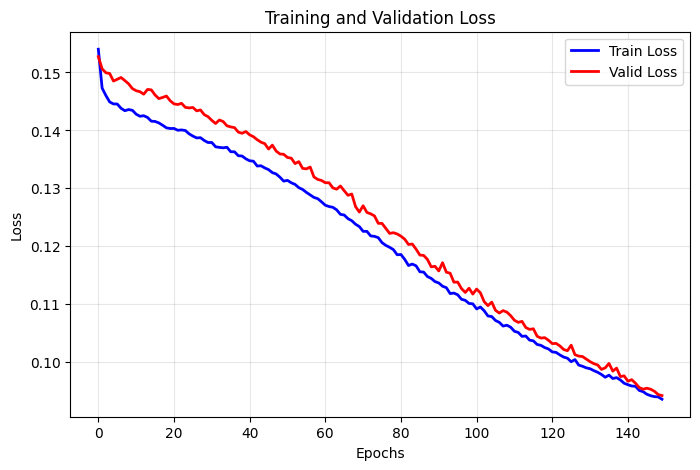

In [26]:
plot_history(history['train_loss'], history['valid_loss'])

## 4. Test on one example

In [ ]:
def make_prediction(model: nn.Module, observation: np.array, question: float, device: torch.device = torch.device('cpu')) -> float:
    torch.cuda.empty_cache()
    
    model.to(device).eval()
    observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
    question_tensor = torch.tensor([[question]], dtype=torch.float32).to(device)
    with torch.no_grad():
        possible_answer, _, _ = model(observation_tensor, question_tensor)
    return possible_answer.item()

In [28]:
def plot_prediction(observation, question, answer, possible_answer) -> None:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(observation, label='Observation', color='blue')
    plt.scatter(question, possible_answer, color='red', label='Prediction', zorder=5)
    plt.scatter(question, answer, color='green', label='True Answer', zorder=5)
    plt.title('Pendulum Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()
    return None

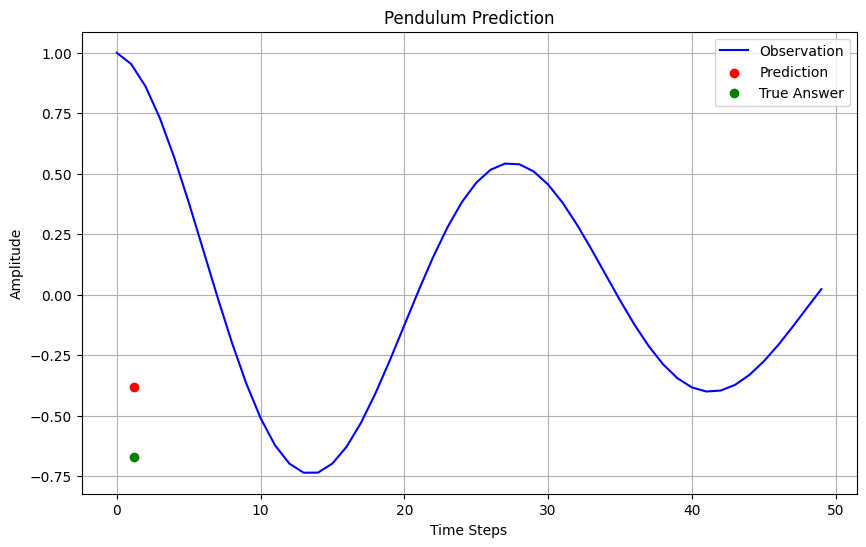

In [65]:
N_samples = 1
kapa_range = (4.5, 5.5)
b_range = (0.4, 0.6)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

possible_answer = make_prediction(pendulum_net, observations[0], questions[0], device=device)
plot_prediction(observations[0], questions[0], answers[0], possible_answer)